In [1]:
import os
import sys
sys.path.append("..")
import canon

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm
from mpl_toolkits.axes_grid1 import Grid
from PIL import Image
%matplotlib inline

import tensorflow as tf
import keras, keras.layers as L, keras.backend as K

from canon.autoencode.feeder import ImageDataFeeder

IMAGE_DIR = "img/processed_981"
TEST_DIR = "img/test_981"
filenames = [filename for filename in os.listdir(IMAGE_DIR)]
IMAGE_SHAPE = (128, 128)
feeder = ImageDataFeeder(IMAGE_SHAPE, batch_size=30, training_dir=IMAGE_DIR, test_dir=TEST_DIR)
X_test = feeder.get_test_set()
print(X_test.shape, X_test.max(), X_test.min())

Using TensorFlow backend.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0550s.) Setting batch_size=6.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: 

(100, 128, 128) 1.0 0.0


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.6s finished


In [4]:
import canon.autoencode
from canon.autoencode import reset_tf_session
from canon.autoencode.models import load_encoder, load_decoder

s = reset_tf_session()
model_name = "ae_128_4_conv_4"
encoder = load_encoder(model_name)
decoder = load_decoder(model_name)
encoder.summary()
decoder.summary()

inp = L.Input(IMAGE_SHAPE)
code = encoder(inp)
reconstruction = decoder(code)
autoencoder = keras.models.Model(inputs=inp, outputs=reconstruction)
autoencoder.compile(optimizer="adadelta", loss='binary_crossentropy')
reconstruction_mse = autoencoder.evaluate(X_test, X_test, verbose=1)
print("Convolutional Autoencoder Binary CrossEntropy:", reconstruction_mse)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 128, 128)          0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 128, 128, 1)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 16)      160       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 16)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 64, 64, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 32)        4640      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 32, 32, 32)        0         
__________

image 67
image 29
image 13
image 5
image 66


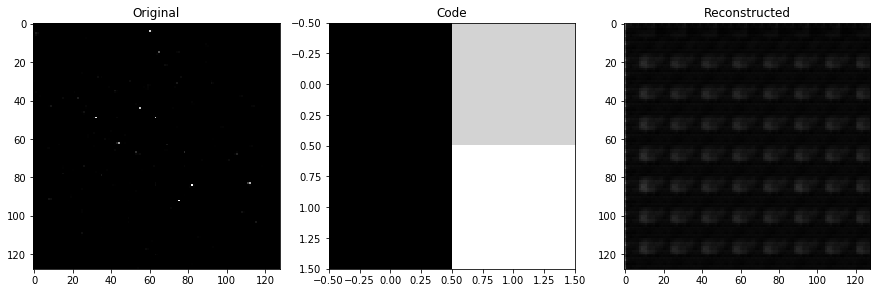

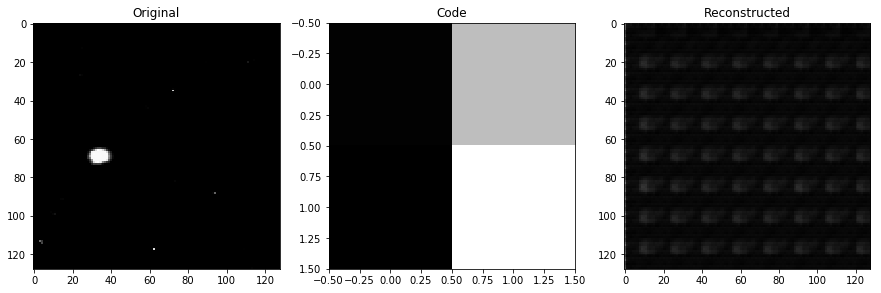

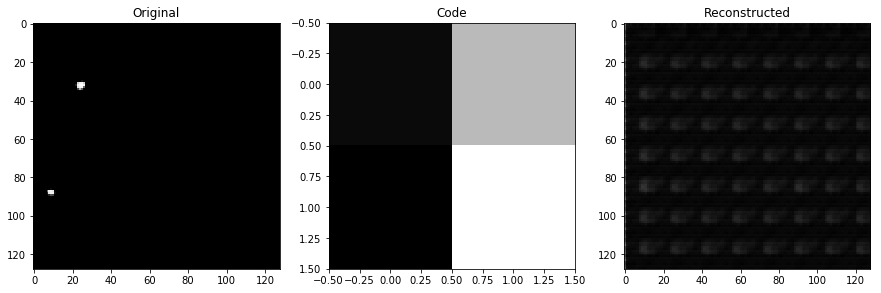

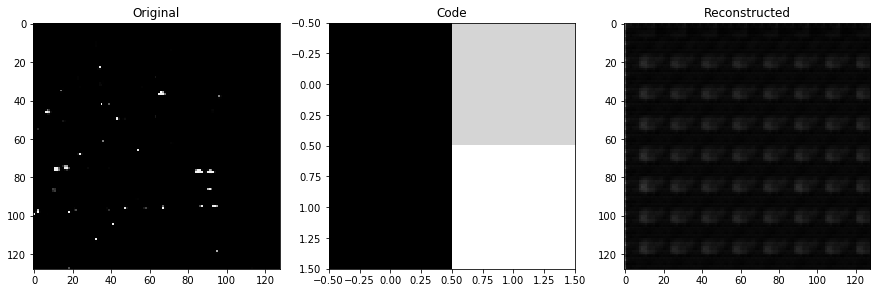

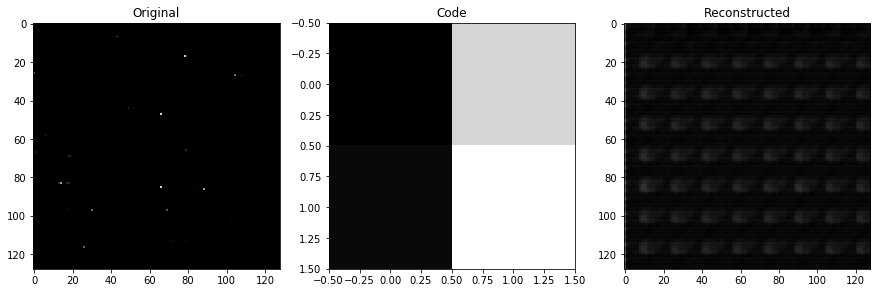

In [5]:
from IPython.display import clear_output

def visualize(img,encoder,decoder):
    """Draws original, encoded and decoded images"""
    code = encoder.predict(img[None])[0]  # img[None] is the same as img[np.newaxis, :]
    reco = decoder.predict(code[None])[0]

    plt.figure(figsize=(15,75))
    
    plt.subplot(1,3,1)
    plt.title("Original")
    plt.imshow(img, cmap='gray')

    plt.subplot(1,3,2)
    plt.title("Code")
    plt.imshow(code.reshape([int(np.ceil(np.sqrt(code.shape[-1]))),-1]), cmap='gray')

    plt.subplot(1,3,3)
    plt.title("Reconstructed")
    plt.imshow(reco, cmap='gray')

# image 96, 25, 99, 49, 64, 2
clear_output()  
for i in np.random.choice(len(X_test), 5):
    img = X_test[i]
    print("image", i)
    visualize(img, encoder, decoder)

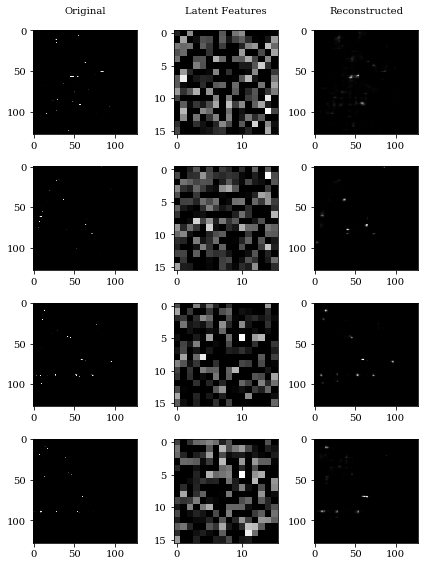

In [49]:
#fig = plt.figure(figsize=(5, 5))
#ax = Grid(fig, rect='111', nrows_ncols=(6,3), axes_pad=0, label_mode='L',)
from matplotlib import rcParams
rcParams['font.size'] = 10
rcParams['font.family'] = 'serif'
rcParams['font.sans-serif'] = ['Times New Roman']
fig, ax = plt.subplots(ncols=3, nrows=4, figsize=(6, 8))

clear_output()  
for i, img_idx in enumerate([96, 25, 99, 49]):
# for i in np.random.choice(len(X_test), 5):
    img = X_test[i]
    
    code = encoder.predict(img[None])[0]  # img[None] is the same as img[np.newaxis, :]
    reco = decoder.predict(code[None])[0]

    ax1 = ax[i, 0]
    ax1.imshow(img, cmap='gray')

    ax2 = ax[i, 1]
    ax2.imshow(code.reshape([int(np.ceil(np.sqrt(code.shape[-1]))),-1]), cmap='gray')

    ax3 = ax[i, 2]
    ax3.imshow(reco, cmap='gray')

ax[0, 0].set_title("Original\n", fontsize=10)
ax[0, 1].set_title("Latent Features\n", fontsize=10)
ax[0, 2].set_title("Reconstructed\n", fontsize=10)
plt.tight_layout()
fig.savefig("img/review_model.pdf", dpi=300)

In [5]:
%matplotlib inline